In [1]:
# Import main packages 
from tilepy.include.ObservationScheduler import GetSchedule
from tilepy.include.PointingTools import ObservationParameters, NextWindowTools, getdate
import time
import argparse
import os
from pathlib import Path

/Users/md274436/software/miniforge3/envs/tilepy/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
/Users/md274436/software/miniforge3/envs/tilepy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Set of inputs needed to run the code

In [3]:
# Type of followup, options: gbm, gbmpng or gw
alertType = 'gbm'

# The url to the FITS file with the sky localization in a healpix format (fits file with name starting by glg_healpix
skymap = 'https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2024/bn240612503/current/glg_healpix_all_bn240612503_v00.fit'

# Date and time of the event in format YYYY-MM-DD HH:MM:SS. You can use 2023-07-15 14:30:10 for the example .fits file
#obsTime = getdate("2023-12-06  23:39:01")
#obsTime = getdate("2024-04-13  02:33:01")
obsTime = getdate("2023-06-10 14:51:47")

# Path to the input datasets (where galaxy cat should be for GW case)
datasetDir = '../../tilepy/dataset/'

# Path to the output folder
outDir = './output'

# Config file for the tiling scheduling
cfgFile = '../config/FollowupParameters_CTAOS.ini'

# Tiles already observed
pointingsFile = None

# Limit on skyloc to perform a followup
locCut = None

In [4]:
# Create forder for output
if not os.path.exists(outDir):
    os.makedirs(outDir)

In [5]:
#Parse the parameters 
obspar = ObservationParameters()
obspar.add_parsed_args(skymap,obsTime,datasetDir,None,outDir,pointingsFile,alertType,locCut)
obspar.from_configfile(cfgFile)

### Run the scheduling

The file is already existing, it will be re-downloaded


Starting the 2D pointing calculation with the following parameters

Filename:  GRB240612503
Date:  2023-06-10 14:51:47
Previous pointings:  None
Dataset:  ../../tilepy/dataset/
Output:  ./output/GRB240612503

============== Main parsed observation parameters ==============  
Observatory Name: CTAO-S
Observatory: -24.5 deg
Observatory: -70.17 deg
Observatory: 2635.0 m
Max zenith: 60
Using Greytime is: True
FOV: 4.0
Max runs: 20
Duration: 20
High Resolution NSIDE: 512
Low Resolution NSIDE: 128
The strategy is (3D, integrated, mangrove=False)
The level of details is (doPlot=True, doRank = True)


-------------------   NEW EVENT   --------------------

----------   NEW FOLLOW-UP ATTEMPT   ----------

Total GW probability covered:  0.9384 Number of runs that fulfill darkness condition  : 32 Number of effective pointings:  7

================================= Tiling found =============================================
     Time[UTC]      RA[deg]  DEC[deg]  PGW   Round ObsName Duration FoV
---

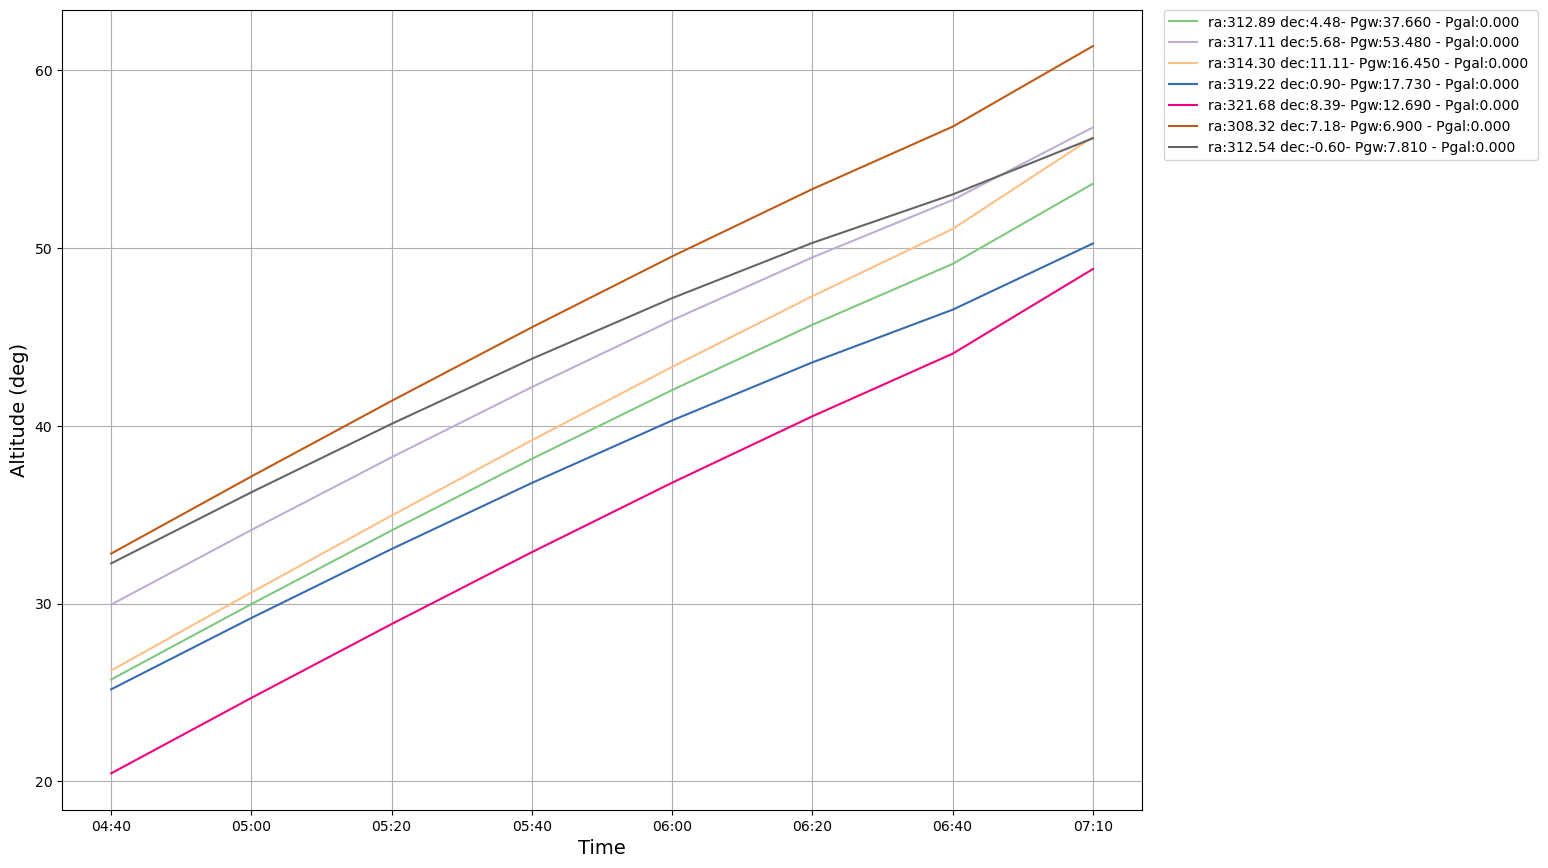

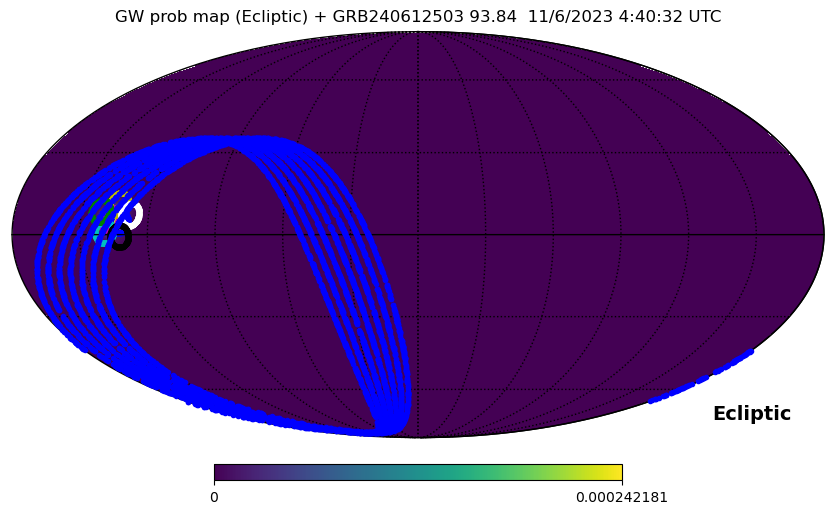

In [6]:
GetSchedule(obspar)